Preprocessing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

doc_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/My Folder/topic_model_train_new.csv')

import nltk
from nltk.tokenize import word_tokenize
import re

# Load stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Load punk_tab
import string # to remove punctuations
nltk.download('punkt_tab')

# Load SpaCy to use its Lemmatization function
import spacy
nlp = spacy.load("en_core_web_sm", disable = ['ner','parser'])

# Define additional stopwords common in the pyLDAvis visualization
custom_stopwords = set([
    "author", "learn", "description", "method", "result",
    "paper", "study", "analysis", "research", "use", "model",
    "approach", "different", "propose", "find", "work", "differ",
    "new", "set", "paper", "show", "information", "process", "present",
    "process", "approach", "problem", "gross"
])

# Merge with NLTK's stopwords
all_stopwords = set(stopwords.words('english')).union(custom_stopwords)


def my_preprocessing(text):
  text_processed = []
  #step 0: remove the extra line separaters
  text_one_line = text.replace('\n',' ')
  #step 1: lower case
  text_lower = text_one_line.lower()
  #step 2: remove math expressions and numbers
  text_wo_math = re.sub(r'\$.*?\$', '', text_lower)
  text_wo_numbers = re.sub(r'\d+', '', text_wo_math)
  #step 3: remove stopwords and punctuations
  tokens = word_tokenize(text_wo_numbers)
  tokens_processed = []
  for token in tokens:
    if (token not in string.punctuation) and (token not in all_stopwords):
      tokens_processed.append(token)
  #step 4: lemmatization using SpaCy and also remove short words
  text_processed = ' '.join(tokens_processed)
  allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
  doc = nlp(text_processed)
  token_lemma = [token.lemma_ for token in doc if (token.pos_ in allowed_postags) and (len(token) > 2)]
  text_processed = ' '.join(token_lemma)
  return text_processed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
sample_corpus = doc_df['ABSTRACT'].sample(5)

# do your test here
for text in sample_corpus:
  print(text)
  print(my_preprocessing(text))
  print('\n')

  Generative models have long been the dominant approach for speech
recognition. The success of these models however relies on the use of
sophisticated recipes and complicated machinery that is not easily accessible
to non-practitioners. Recent innovations in Deep Learning have given rise to an
alternative - discriminative models called Sequence-to-Sequence models, that
can almost match the accuracy of state of the art generative models. While
these models are easy to train as they can be trained end-to-end in a single
step, they have a practical limitation that they can only be used for offline
recognition. This is because the models require that the entirety of the input
sequence be available at the beginning of inference, an assumption that is not
valid for instantaneous speech recognition. To address this problem, online
sequence-to-sequence models were recently introduced. These models are able to
start producing outputs as data arrives, and the model feels confident enough
to out

LDA Model

In [ ]:
!pip install numpy --upgrade
!pip install gensim --upgrade --force-reinstall

# Use TF-IDF vectorizer to turn abstracts into vectors
from sklearn.feature_extraction.text import TfidfVectorizer
my_vectorizer = TfidfVectorizer(preprocessor=my_preprocessing, max_features = 5000)
abstract_vectorized = my_vectorizer.fit_transform(doc_df['ABSTRACT'])

from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
from gensim import corpora

coherence_scores = {}

# Try different numbers of topics
for num_topics in [5, 7, 9, 11]:  # Try different values for n_components
    print(f"Training LDA with {num_topics} topics...")

    lda_model = LatentDirichletAllocation(n_components=num_topics, # Number of topics
                                    doc_topic_prior = None, # Default is 1/n_documents
                                    topic_word_prior = None, # Default is 1/n_documents
                                    learning_method='online',  # Decide how often the training will update the model. Will be faster to do it "online" vs "batch"
                                    random_state= 42,
                                    max_iter=10) # The number of epoches for the training (how many times you wlll go through the entire corpus)

    lda_top=lda_model.fit_transform(abstract_vectorized)

        # Function to extract topic words from Scikit-Learn LDA
    def get_sklearn_topics(model, feature_names, n_top_words=10):
        topics = []
        for topic_idx, topic in enumerate(model.components_):
            top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
            topics.append(top_words)
        return topics

    # Get feature names and extract topics
    feature_names = my_vectorizer.get_feature_names_out()
    sklearn_topics = get_sklearn_topics(lda_model, feature_names)

    # Convert preprocessed text data into tokenized form
    doc_df['Processed'] = doc_df['ABSTRACT'].apply(lambda x: my_preprocessing(x).split())  # Convert preprocessed text into list of words
    dictionary = corpora.Dictionary(doc_df['Processed'])
    corpus = [dictionary.doc2bow(text) for text in doc_df['Processed']]

    coherence_model_sklearn = CoherenceModel(topics=sklearn_topics, texts=doc_df['Processed'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_sklearn.get_coherence()
    coherence_scores[num_topics] = coherence_score

    print(f"Coherence Score for {num_topics} topics: {coherence_score}")

print("Final Coherence Scores:")
for k, v in coherence_scores.items():
    print(f"{k} Topics: {v}")


  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (

In [ ]:
# Train LDA model with the best number of topics (5)
best_num_topics = 5  # Since 5 had the highest coherence score

lda_model_best = LatentDirichletAllocation(n_components=best_num_topics,
                                           learning_method='online',
                                           random_state=42,
                                           max_iter=10)

# Fit the model with TF-IDF matrix
lda_top_best = lda_model_best.fit_transform(abstract_vectorized)

In [ ]:
def get_sklearn_topics(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(top_words)
    return topics

# Get feature names and extract topics
feature_names = my_vectorizer.get_feature_names_out()
sklearn_topics = get_sklearn_topics(lda_model_best, feature_names)

perplexity_score = lda_model_best.perplexity(abstract_vectorized)

print(f"Scikit-Learn LDA Perplexity Score: {perplexity_score}")

Scikit-Learn LDA Perplexity Score: 3953.130027421581


In [ ]:
# Print out the top 10 word tokens in each topic
vocab = my_vectorizer.get_feature_names_out()
for i, comp in enumerate(lda_model_best.components_):
    terms_comp = zip(vocab, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0],end=" ")
    print("\n")


Topic 0: 
network learn neural image deep datum learning task model training 

Topic 1: 
equation function prove space give group solution graph case number 

Topic 2: 
network system datum use base time user design propose control 

Topic 3: 
estimator gradient optimization convergence convex optimal stochastic algorithm descent rate 

Topic 4: 
phase energy field magnetic spin temperature state wave effect system 



In [ ]:
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.lda_model as sklearnvis

pyLDAvis.enable_notebook()
vis_data = sklearnvis.prepare(lda_model_best, abstract_vectorized, my_vectorizer)
pyLDAvis.display(vis_data)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.1 MB/s eta 0:00:00


Testing of Embedding + Clustering Techniques

In [ ]:
# Sample df
sample_df = doc_df.sample(2000, ignore_index = True)
sample_docs = sample_df['ABSTRACT'].tolist()

docs = sample_docs

# Model df
model_docs = doc_df['ABSTRACT'].tolist()

Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

tagged_docs = []
for i,doc in enumerate(docs):
  tagged_docs.append(TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]))

# train the Doc2vec model
model = Doc2Vec(vector_size=20,
                min_count=2,
                epochs=50)
model.build_vocab(tagged_docs)
model.train(tagged_docs,
            total_examples=model.corpus_count,
            epochs=model.epochs)

# get the document vectors
document_vectors = [model.infer_vector(word_tokenize(my_preprocessing(doc))) for doc in docs]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


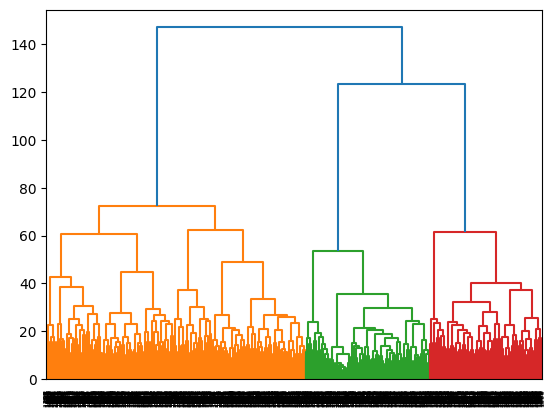

In [ ]:
import scipy.cluster.hierarchy as sc

sc.dendrogram(sc.linkage(document_vectors, method='ward'))
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

for k in range(5, 10):  # Try different cluster numbers
    my_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = my_clustering.fit_predict(document_vectors)
    score = silhouette_score(document_vectors, cluster_labels)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

Clusters: 5, Silhouette Score: 0.0509
Clusters: 6, Silhouette Score: 0.0537
Clusters: 7, Silhouette Score: 0.0581
Clusters: 8, Silhouette Score: 0.0438
Clusters: 9, Silhouette Score: 0.0409


In [ ]:
from sklearn.cluster import KMeans

# Try different cluster numbers with K-Means
for k in range(5, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels_kmeans = kmeans.fit_predict(document_vectors)
    score = silhouette_score(document_vectors, cluster_labels_kmeans)
    print(f"K-Means Clusters: {k}, Silhouette Score: {score:.4f}")

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f5269437240>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error
Exception ignored on calling ctypes callback function: <functio

K-Means Clusters: 5, Silhouette Score: 0.0901
K-Means Clusters: 6, Silhouette Score: 0.0953
K-Means Clusters: 7, Silhouette Score: 0.0790
K-Means Clusters: 8, Silhouette Score: 0.0700
K-Means Clusters: 9, Silhouette Score: 0.0684


SBERT

In [ ]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

sbert_embeddings = sbert_model.encode(docs)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 983.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

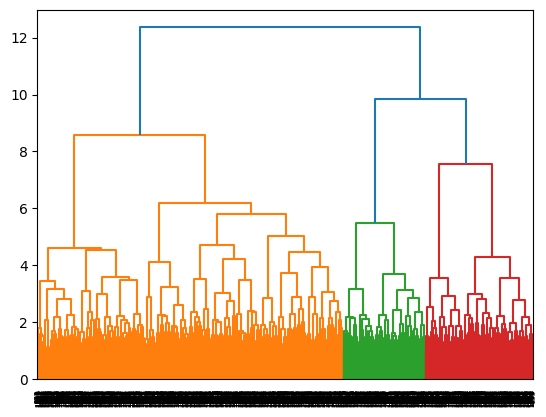

In [ ]:
import scipy.cluster.hierarchy as sc

sc.dendrogram(sc.linkage(sbert_embeddings, method='ward'))
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

for k in range(5, 10):  # Try different cluster numbers
    my_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = my_clustering.fit_predict(sbert_embeddings)
    score = silhouette_score(sbert_embeddings, cluster_labels)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

Clusters: 5, Silhouette Score: 0.0369
Clusters: 6, Silhouette Score: 0.0317
Clusters: 7, Silhouette Score: 0.0346
Clusters: 8, Silhouette Score: 0.0326
Clusters: 9, Silhouette Score: 0.0309


In [ ]:
for k in range(5, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels_kmeans = kmeans.fit_predict(sbert_embeddings)
    score = silhouette_score(sbert_embeddings, cluster_labels_kmeans)
    print(f"K-Means Clusters: {k}, Silhouette Score: {score:.4f}")

K-Means Clusters: 5, Silhouette Score: 0.0484
K-Means Clusters: 6, Silhouette Score: 0.0487
K-Means Clusters: 7, Silhouette Score: 0.0463
K-Means Clusters: 8, Silhouette Score: 0.0456
K-Means Clusters: 9, Silhouette Score: 0.0455


Universal Sentence Embedding

/usr/local/lib/python3.11/dist-packages/tensorflow_hub/__init__.py:61: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  d

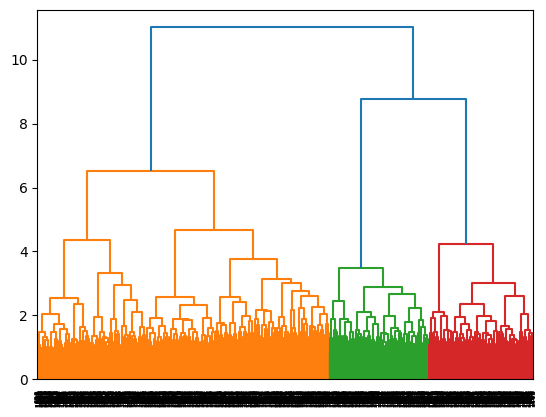

In [ ]:
import tensorflow_hub as hub

use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

use_embeddings = use_model(docs)

sc.dendrogram(sc.linkage(use_embeddings, method='ward'))
plt.show()

In [ ]:
for k in range(5, 10):  # Try different cluster numbers
    my_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = my_clustering.fit_predict(use_embeddings)
    score = silhouette_score(use_embeddings, cluster_labels)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

Clusters: 5, Silhouette Score: 0.0182
Clusters: 6, Silhouette Score: 0.0117
Clusters: 7, Silhouette Score: 0.0115
Clusters: 8, Silhouette Score: 0.0137
Clusters: 9, Silhouette Score: 0.0113


In [ ]:
for k in range(5, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels_kmeans = kmeans.fit_predict(use_embeddings)
    score = silhouette_score(use_embeddings, cluster_labels_kmeans)
    print(f"K-Means Clusters: {k}, Silhouette Score: {score:.4f}")

K-Means Clusters: 5, Silhouette Score: 0.0309
K-Means Clusters: 6, Silhouette Score: 0.0285
K-Means Clusters: 7, Silhouette Score: 0.0237
K-Means Clusters: 8, Silhouette Score: 0.0256
K-Means Clusters: 9, Silhouette Score: 0.0251


Model Build of Doc2Vec + K Means

In [ ]:
model_tagged_docs = [
    TaggedDocument(words=my_preprocessing(doc).split(), tags=[str(i)]) for i, doc in enumerate(doc_df['ABSTRACT'])
]

doc_model = Doc2Vec(vector_size=20, min_count=2, epochs=50, workers=4)

doc_model.build_vocab(model_tagged_docs)

doc_model.train(model_tagged_docs, total_examples=doc_model.corpus_count, epochs=doc_model.epochs)

model_document_vectors = np.array([doc_model.infer_vector(my_preprocessing(doc).split()) for doc in doc_df['ABSTRACT']])


In [ ]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
cluster_labels_kmeans = kmeans.fit_predict(model_document_vectors)

# Compute Silhouette Score
silhouette_kmeans_doc2vec = silhouette_score(model_document_vectors, cluster_labels_kmeans)
print(f"Final K-Means Doc2Vec Silhouette Score: {silhouette_kmeans_doc2vec:.4f}")


doc_df['Cluster'] = cluster_labels_kmeans

# Show some results
print(doc_df[['TITLE', 'Cluster']].head())

Final K-Means Doc2Vec Silhouette Score: 0.0619
                                               TITLE  Cluster
0                 Rotation Invariance Neural Network        0
1  Spherical polyharmonics and Poisson kernels fo...        3
2  Comparative study of Discrete Wavelet Transfor...        0
3  On the rotation period and shape of the hyperb...        5
4  SPH calculations of Mars-scale collisions: the...        5


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

model_docs = doc_df['ABSTRACT'].tolist()

# Convert abstracts into TF-IDF representation
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(model_docs)

# Extract feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Function to get top words for each cluster
def get_top_words_per_cluster(tfidf_matrix, cluster_labels, feature_names, n_words=10):
    clusters = np.unique(cluster_labels)
    top_words = []

    for cluster in clusters:
        # Get indices of documents in the current cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]

        # Extract only the documents belonging to this cluster
        cluster_docs = tfidf_matrix[cluster_indices]

        # Compute average TF-IDF score for each word
        cluster_mean_tfidf = np.asarray(cluster_docs.mean(axis=0)).flatten()

        # Get top words for the cluster
        top_indices = cluster_mean_tfidf.argsort()[-n_words:][::-1]
        top_words.append([feature_names[i] for i in top_indices])

    return top_words

# Extract top words for each cluster
top_words_per_cluster = get_top_words_per_cluster(tfidf_matrix, cluster_labels_kmeans, feature_names)

# Print top words for each cluster
for i, words in enumerate(top_words_per_cluster):
    print(f"Cluster {i}: {', '.join(words)}")

Cluster 0: learning, data, neural, model, deep, network, training, networks, based, models
Cluster 1: data, algorithm, model, problem, method, models, learning, methods, algorithms, based
Cluster 2: spin, magnetic, phase, quantum, field, energy, temperature, model, states, electron
Cluster 3: mathbb, prove, group, space, paper, finite, theory, problem, functions, mathcal
Cluster 4: data, network, time, model, based, systems, paper, control, information, networks
Cluster 5: mass, stars, star, data, galaxies, 10, observations, stellar, galaxy, high


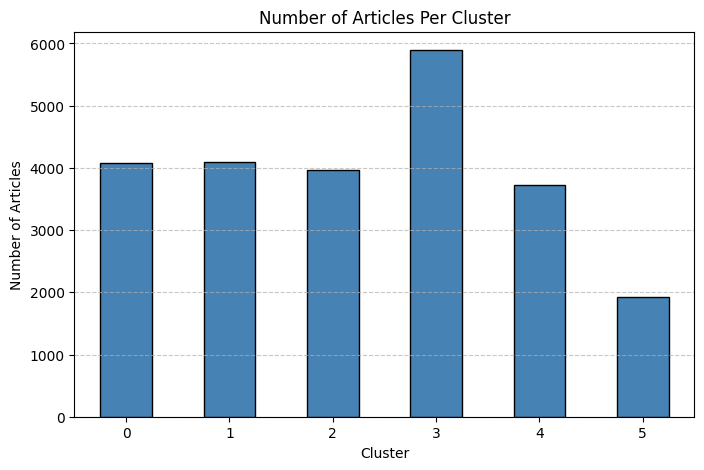

In [ ]:
import matplotlib.pyplot as plt

# Count articles per cluster
cluster_counts = doc_df['Cluster'].value_counts()

# Plot
plt.figure(figsize=(8,5))
cluster_counts.sort_index().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title("Number of Articles Per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Articles")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Exploration of Test Dataset

Computer Science        2549
Physics                 1773
Mathematics             1725
Statistics              1545
Quantitative Biology     166
Quantitative Finance      80
dtype: int64


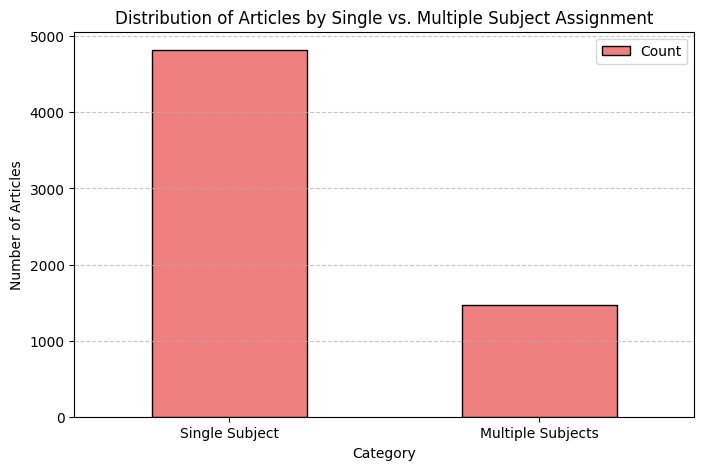

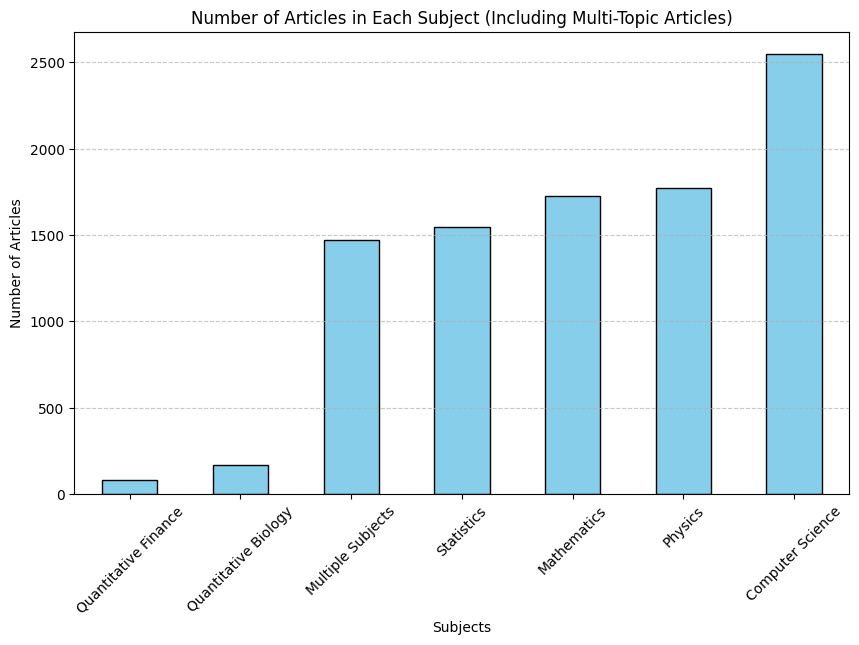

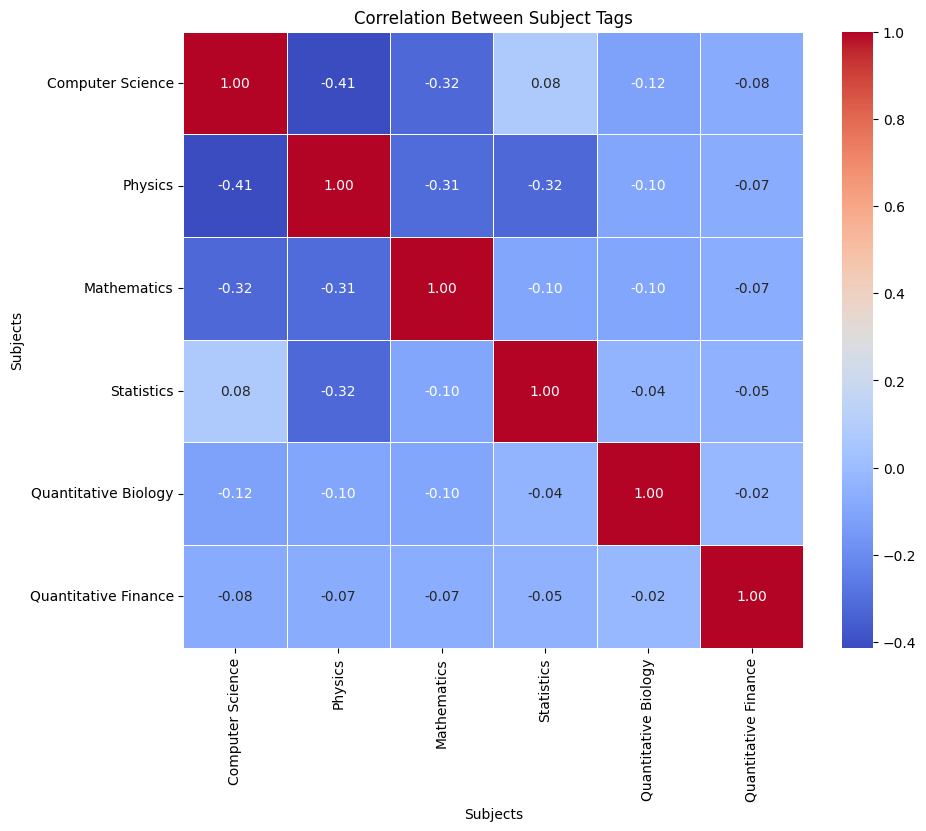

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


doc_df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/My Folder/topic_model_test_new.csv')

doc_df_test.head()

# Sum up the number of articles in each subject
subject_counts = doc_df_test.iloc[:, 3:].sum()  # Summing only subject columns

# Print subject counts
print(subject_counts)

# Count articles with multiple subjects
doc_df_test['num_subjects'] = doc_df_test.iloc[:, 3:].sum(axis=1)  # Sum across rows
multi_topic_count = (doc_df_test['num_subjects'] > 1).sum()  # Count articles in multiple subjects

# Add multi-topic count to the subject count dictionary
subject_counts["Multiple Subjects"] = multi_topic_count
# Count articles with single and multiple topics
single_topic_count = (doc_df_test['num_subjects'] == 1).sum()
multi_topic_count = (doc_df_test['num_subjects'] > 1).sum()

# Create a DataFrame for visualization
topic_distribution = pd.DataFrame({
    'Count': [single_topic_count, multi_topic_count]
}, index=['Single Subject', 'Multiple Subjects'])

# Plot
topic_distribution.plot(kind='bar', color=['lightcoral', 'steelblue'], edgecolor='black', figsize=(8,5))
plt.title("Distribution of Articles by Single vs. Multiple Subject Assignment")
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

plt.figure(figsize=(10,6))
subject_counts.sort_values().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Number of Articles in Each Subject (Including Multi-Topic Articles)")
plt.xlabel("Subjects")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

# Selecting only subject columns for correlation analysis
subject_columns = doc_df_test.iloc[:, 3:-1]  # Excludes num_subjects column
correlation_matrix = subject_columns.corr()

# Compute correlation matrix
correlation_matrix = subject_columns.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Correlation Between Subject Tags")
plt.xlabel("Subjects")
plt.ylabel("Subjects")

plt.show()

Testing LDA Model

In [ ]:
abstract_vectorized_test = my_vectorizer.transform(doc_df_test['ABSTRACT'])


lda_top_test = lda_model_best.transform(abstract_vectorized_test)
lda_top_test.shape

topic_df_test = pd.DataFrame(lda_top_test)
topic_df_test.columns = ['topic_' + str(i) for i in range(topic_df_test.shape[1])]
topic_df_test.reset_index(drop=True)

topic_df_test['topic_with_highest_score'] = topic_df_test.idxmax(axis=1)

doc_df_test_with_topics = pd.concat([doc_df_test, topic_df_test], axis=1)

doc_df_test_with_topics.info()
doc_df_test_with_topics.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6292 entries, 0 to 6291
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        6292 non-null   int64  
 1   TITLE                     6292 non-null   object 
 2   ABSTRACT                  6292 non-null   object 
 3   Computer Science          6292 non-null   int64  
 4   Physics                   6292 non-null   int64  
 5   Mathematics               6292 non-null   int64  
 6   Statistics                6292 non-null   int64  
 7   Quantitative Biology      6292 non-null   int64  
 8   Quantitative Finance      6292 non-null   int64  
 9   num_subjects              6292 non-null   int64  
 10  topic_0                   6292 non-null   float64
 11  topic_1                   6292 non-null   float64
 12  topic_2                   6292 non-null   float64
 13  topic_3                   6292 non-null   float64
 14  topic_4 

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,num_subjects,topic_0,topic_1,topic_2,topic_3,topic_4,topic_with_highest_score
0,20212,Cloudless atmospheres for young low-gravity su...,Atmospheric modeling of low-gravity (VL-G) y...,0,1,0,0,0,0,1,0.027785,0.026583,0.027126,0.033893,0.884613,topic_4
1,9175,Sample complexity of population recovery,The problem of population recovery refers to...,1,0,1,1,0,0,3,0.027946,0.314766,0.280768,0.350869,0.025651,topic_3
2,13468,Regular Separability of Well Structured Transi...,We investigate the languages recognized by w...,1,0,0,0,0,0,1,0.040554,0.841542,0.039490,0.039311,0.039104,topic_1
3,2165,Standard Zero-Free Regions for Rankin--Selberg...,We give a simple proof of a standard zero-fr...,0,0,1,0,0,0,1,0.046114,0.815609,0.046020,0.045355,0.046903,topic_1
4,3619,Towards Visual Explanations for Convolutional ...,The predictive power of neural networks ofte...,1,0,0,1,0,0,2,0.724497,0.028467,0.189715,0.028301,0.029020,topic_0


In [ ]:
topic_labels = ['Computer Science',	'Physics', 'Mathematics',	'Statistics',	'Quantitative Biology','Quantitative Finance']

for i in range(best_num_topics):
  topic_lda= 'topic_' + str(i)
  for topic_label in topic_labels:
    temp_df = doc_df_test_with_topics[doc_df_test_with_topics['topic_with_highest_score'] == topic_lda]
    print(topic_lda, '->', topic_label, temp_df[topic_label].sum())
  print('\n')

topic_0 -> Computer Science 705
topic_0 -> Physics 24
topic_0 -> Mathematics 39
topic_0 -> Statistics 610
topic_0 -> Quantitative Biology 12
topic_0 -> Quantitative Finance 1


topic_1 -> Computer Science 389
topic_1 -> Physics 238
topic_1 -> Mathematics 1393
topic_1 -> Statistics 270
topic_1 -> Quantitative Biology 12
topic_1 -> Quantitative Finance 15


topic_2 -> Computer Science 1363
topic_2 -> Physics 276
topic_2 -> Mathematics 217
topic_2 -> Statistics 568
topic_2 -> Quantitative Biology 129
topic_2 -> Quantitative Finance 64


topic_3 -> Computer Science 68
topic_3 -> Physics 1
topic_3 -> Mathematics 45
topic_3 -> Statistics 89
topic_3 -> Quantitative Biology 0
topic_3 -> Quantitative Finance 0


topic_4 -> Computer Science 24
topic_4 -> Physics 1234
topic_4 -> Mathematics 31
topic_4 -> Statistics 8
topic_4 -> Quantitative Biology 13
topic_4 -> Quantitative Finance 0




In [ ]:
# Create a dictionary to store the assigned labels
topic_to_label = {}

# Loop through each LDA topic and assign the most frequent real label
for i in range(best_num_topics):
    topic_lda = 'topic_' + str(i)

    # Subset only documents assigned to this topic
    temp_df = doc_df_test_with_topics[doc_df_test_with_topics['topic_with_highest_score'] == topic_lda]

    # Find the most common real label in this topic
    most_common_label = temp_df[topic_labels].sum().idxmax()

    # Store in the dictionary
    topic_to_label[topic_lda] = most_common_label

# Display assigned topic labels
print("Assigned Topic Labels:", topic_to_label)

Assigned Topic Labels: {'topic_0': 'Computer Science', 'topic_1': 'Mathematics', 'topic_2': 'Computer Science', 'topic_3': 'Statistics', 'topic_4': 'Physics'}


In [ ]:
# Column to store the predicted subject based on LDA topics
doc_df_test_with_topics['Predicted_Subject'] = doc_df_test_with_topics['topic_with_highest_score'].map(topic_to_label)

# Show some results
print(doc_df_test_with_topics[['TITLE', 'topic_with_highest_score', 'Predicted_Subject']].head())

                                               TITLE topic_with_highest_score  \
0  Cloudless atmospheres for young low-gravity su...                  topic_4   
1           Sample complexity of population recovery                  topic_3   
2  Regular Separability of Well Structured Transi...                  topic_1   
3  Standard Zero-Free Regions for Rankin--Selberg...                  topic_1   
4  Towards Visual Explanations for Convolutional ...                  topic_0   

  Predicted_Subject  
0           Physics  
1        Statistics  
2       Mathematics  
3       Mathematics  
4  Computer Science  


In [ ]:
from sklearn.metrics import classification_report

# Get true labels (real subject per document)
true_labels = doc_df_test_with_topics[topic_labels].idxmax(axis=1)

# Get predicted labels (LDA assigned subjects)
predicted_labels = doc_df_test_with_topics['Predicted_Subject']

# Compute classification report
print(classification_report(true_labels, predicted_labels))

                      precision    recall  f1-score   support

    Computer Science       0.69      0.81      0.74      2549
         Mathematics       0.63      0.86      0.73      1378
             Physics       0.96      0.75      0.84      1628
Quantitative Biology       0.00      0.00      0.00       132
Quantitative Finance       0.00      0.00      0.00        71
          Statistics       0.16      0.04      0.06       534

            accuracy                           0.72      6292
           macro avg       0.41      0.41      0.40      6292
        weighted avg       0.68      0.72      0.68      6292



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testing Doc2Vec Model

In [ ]:
from scipy.spatial.distance import cdist
from sklearn.metrics import classification_report


test_docs = doc_df_test['ABSTRACT'].tolist()

test_vectors = np.array([doc_model.infer_vector(my_preprocessing(doc).split()) for doc in test_docs])

closest_clusters = np.argmin(cdist(test_vectors, kmeans.cluster_centers_), axis=1)

# Store test cluster assignments
doc_df_test['Predicted_Cluster'] = closest_clusters

# Show results
print(doc_df_test[['TITLE', 'Predicted_Cluster']].head())


                                               TITLE  Predicted_Cluster
0  Cloudless atmospheres for young low-gravity su...                  5
1           Sample complexity of population recovery                  1
2  Regular Separability of Well Structured Transi...                  3
3  Standard Zero-Free Regions for Rankin--Selberg...                  3
4  Towards Visual Explanations for Convolutional ...                  0


In [ ]:
cluster_topic_counts = {}

# Loop through each cluster
for cluster in np.unique(closest_clusters):
    print(f"\nCluster {cluster}")  # Print cluster header

    # Subset only documents assigned to this cluster
    temp_df = doc_df_test[doc_df_test['Predicted_Cluster'] == cluster]

    # Loop through all subject labels and print counts
    for topic_label in topic_columns:
        topic_count = temp_df[topic_label].sum()
        print(f"Cluster {cluster} -> {topic_label}: {topic_count}")


Cluster 0
Cluster 0 -> Computer Science: 801
Cluster 0 -> Physics: 34
Cluster 0 -> Mathematics: 10
Cluster 0 -> Statistics: 475
Cluster 0 -> Quantitative Biology: 36
Cluster 0 -> Quantitative Finance: 0

Cluster 1
Cluster 1 -> Computer Science: 479
Cluster 1 -> Physics: 55
Cluster 1 -> Mathematics: 372
Cluster 1 -> Statistics: 821
Cluster 1 -> Quantitative Biology: 23
Cluster 1 -> Quantitative Finance: 30

Cluster 2
Cluster 2 -> Computer Science: 56
Cluster 2 -> Physics: 927
Cluster 2 -> Mathematics: 55
Cluster 2 -> Statistics: 20
Cluster 2 -> Quantitative Biology: 39
Cluster 2 -> Quantitative Finance: 2

Cluster 3
Cluster 3 -> Computer Science: 392
Cluster 3 -> Physics: 190
Cluster 3 -> Mathematics: 1191
Cluster 3 -> Statistics: 79
Cluster 3 -> Quantitative Biology: 9
Cluster 3 -> Quantitative Finance: 11

Cluster 4
Cluster 4 -> Computer Science: 808
Cluster 4 -> Physics: 102
Cluster 4 -> Mathematics: 93
Cluster 4 -> Statistics: 129
Cluster 4 -> Quantitative Biology: 51
Cluster 4 -> 

In [ ]:
topic_columns = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']

# Find the majority label for each cluster
cluster_topic_mapping = {}

for cluster in np.unique(closest_clusters):
    cluster_indices = doc_df_test['Predicted_Cluster'] == cluster
    majority_topic = doc_df_test.loc[cluster_indices, topic_columns].sum().idxmax()
    cluster_topic_mapping[cluster] = majority_topic

# Assign mapped topics
doc_df_test['Mapped_Topic'] = doc_df_test['Predicted_Cluster'].map(cluster_topic_mapping)

# Show some results
print(doc_df_test[['TITLE', 'Predicted_Cluster', 'Mapped_Topic']].head())

                                               TITLE  Predicted_Cluster  \
0  Cloudless atmospheres for young low-gravity su...                  5   
1           Sample complexity of population recovery                  1   
2  Regular Separability of Well Structured Transi...                  3   
3  Standard Zero-Free Regions for Rankin--Selberg...                  3   
4  Towards Visual Explanations for Convolutional ...                  0   

       Mapped_Topic  
0           Physics  
1        Statistics  
2       Mathematics  
3       Mathematics  
4  Computer Science  


In [ ]:
# Get true labels
true_labels = doc_df_test[topic_columns].idxmax(axis=1)  # Assigns each article its actual topic
predicted_labels = doc_df_test['Mapped_Topic']

# Compute classification report
print(classification_report(true_labels, predicted_labels))

                      precision    recall  f1-score   support

    Computer Science       0.80      0.63      0.71      2549
         Mathematics       0.63      0.74      0.68      1378
             Physics       0.89      0.84      0.86      1628
Quantitative Biology       0.00      0.00      0.00       132
Quantitative Finance       0.00      0.00      0.00        71
          Statistics       0.25      0.53      0.34       534

            accuracy                           0.68      6292
           macro avg       0.43      0.46      0.43      6292
        weighted avg       0.71      0.68      0.69      6292



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
